In [180]:
#import the necessary fucntion 
from parameters_cov_AI import parameter_csv
import numpy as np

In [185]:
raw_data = pd.read_csv('camp_raw_data/moria_params.csv')

def preparePopulationFrame(camp_name):
    
    population_size = raw_data.loc[:,['Variable','Camp','Value']]
    population_size = population_size[population_size.Camp == camp_name]

    population_frame = raw_data[raw_data.Camp==camp_name]
    population_frame = population_frame[population_frame['Variable']=='Population_structure']
    population_frame = population_frame.loc[:,'Age':]


    frac_symptomatic = 0.55 # so e.g. 40% that weren't detected were bc no symptoms and the rest (5%) didn't identify vs e.g. flu
    population_frame = population_frame.assign(p_hospitalised = lambda x: (x.Hosp_given_symptomatic/100)*frac_symptomatic,
                    p_critical = lambda x: (x.Critical_given_hospitalised/100)) 

    population_frame = population_frame.rename(columns={'Value': "Population"})


#     population_size = population_size[population_size['Variable']=='Total_population']
#     population_size = np.float(population_size.Value)
    population_size=20000

    return population_frame, population_size



example_population_frame, example_population = preparePopulationFrame('Moria')

In [194]:
#------------------------------------------------------------
# disease params
model_params = parameter_csv[parameter_csv['Type']=='Model Parameter']
model_params = model_params.loc[:,['Name','Value']]
# print()
n_Rs = 20
# Controlled transmission 
R0_low = np.random.uniform(1.5,2,n_Rs)
# Moderate transmission
R0_mid = np.random.uniform(2,3,n_Rs)
# Inflated transmission (inflated by the diphtheria inflation factor)
R0_high = np.random.uniform(2*1.65,3*1.65,n_Rs)

# R_0                 = np.float(model_params[model_params['Name']=='R0'].Value)
become_infectious_rate     = 1/(np.float(model_params[model_params['Name']=='infectious_period'].Value))
no_longer_infectious_rate = 1/(np.float(model_params[model_params['Name']=='non_infectious_period'].Value))
hosp_rate           = 1/(np.float(model_params[model_params['Name']=='hosp_period'].Value))
death_rate          = 1/(np.float(model_params[model_params['Name']=='death_period'].Value))

# beta                = R_0*no_longer_infectious_rate # R_0 mu/N, N=1
# infection_matrix    = beta*np.ones((example_population_frame.shape[0],example_population_frame.shape[0]))
death_prob          = np.float(model_params[model_params['Name']=='death_prob'].Value)
number_compartments = int(model_params[model_params['Name']=='number_compartments'].Value)


# Parameters that may come into play later:
# ICU_capacity = 8/100000
# death prob and period given ICU care:
# import_rate = 1/(30*population) # 1 per month

In [195]:
class Parameters:
    def __init__(self,R_0):
        
        self.R_0 = R_0
        self.no_longer_infectious_rate = no_longer_infectious_rate
        self.beta = R_0*no_longer_infectious_rate # R_0 mu/N, N=1
        self.infection_matrix = self.beta*np.ones((example_population_frame.shape[0],example_population_frame.shape[0]))


        self.number_compartments = number_compartments

        self.become_infectious_rate  = become_infectious_rate
        self.hosp_rate = hosp_rate        
        self.death_rate = death_rate
        self.death_prob     = death_prob

        self.S_ind = 0
        self.E_ind = 1
        self.I_ind = 2
        self.R_ind = 3
        self.H_ind = 4
        self.C_ind = 5
        self.D_ind = 6


In [196]:
#generate parameter lists for each category of R0
params_low=[]
for R0 in R0_low:
    params_low.append(Parameters(R0))
params_mid=[]
for R0 in R0_mid:
    params_mid.append(Parameters(R0))
params_high=[]
for R0 in R0_high:
    params_high.append(Parameters(R0))

In [197]:
from math import exp, ceil, log, floor, sqrt
import numpy as np
from scipy.integrate import ode
from scipy.stats import norm, gamma
import pandas as pd
##
# -----------------------------------------------------------------------------------
##
class Simulator:
    def __init__(self,params):
        self.params=params
    ##
#-----------------------------------------------------------------
        
    ##
    def ode_system(self,t,y,population_frame,control_time,beta_factor):
        ##
        dydt = np.zeros(y.shape)

        I_vec = [ y[self.params.I_ind+i*self.params.number_compartments] for i in range(population_frame.shape[0])] # age_categories

        if t > control_time[0] and t < control_time[1]: # control in place
            control_factor = beta_factor
        else:
            control_factor = 1
            


        for i in range(population_frame.shape[0]): # age_categories
            # S
            dydt[self.params.S_ind + i*self.params.number_compartments] = - y[self.params.S_ind + i*self.params.number_compartments] * control_factor * (np.dot(self.params.infection_matrix[i,:],I_vec)) 
            # E
            dydt[self.params.E_ind + i*self.params.number_compartments] = ( y[self.params.S_ind + i*self.params.number_compartments] * control_factor * (np.dot(self.params.infection_matrix[i,:],I_vec))
                                                                - self.params.become_infectious_rate * y[self.params.E_ind + i*self.params.number_compartments])
            # I
            dydt[self.params.I_ind + i*self.params.number_compartments] = (self.params.become_infectious_rate * y[params.E_ind + i*params.number_compartments] - 
                                                                  self.params.no_longer_infectious_rate * y[params.I_ind + i*params.number_compartments])
            # R
            dydt[self.params.R_ind + i*self.params.number_compartments] = (self.params.no_longer_infectious_rate * (1 - population_frame.p_hospitalised[i]) * y[self.params.I_ind + i*self.params.number_compartments] +
                                                                  self.params.hosp_rate * (1 - population_frame.p_critical[i]) * y[self.params.H_ind + i*self.params.number_compartments] + 
                                                                  self.params.death_rate * (1 - self.params.death_prob) * y[self.params.C_ind + i*self.params.number_compartments])
            # H
            dydt[self.params.H_ind + i*self.params.number_compartments] = (self.params.no_longer_infectious_rate * (population_frame.p_hospitalised[i]) * y[self.params.I_ind + i*self.params.number_compartments] -
                                                                  self.params.hosp_rate * y[self.params.H_ind + i*self.params.number_compartments])
            # C
            dydt[self.params.C_ind + i*self.params.number_compartments] = (self.params.hosp_rate  * (population_frame.p_critical[i]) * y[self.params.H_ind + i*self.params.number_compartments] -
                                                                  self.params.death_rate * y[self.params.C_ind + i*self.params.number_compartments])
            # D
            dydt[self.params.D_ind + i*self.params.number_compartments] = self.params.death_rate * (self.params.death_prob) * y[self.params.C_ind + i*self.params.number_compartments]

        return dydt
    ##
    #--------------------------------------------------------------------
    ##
    def run_model(self,T_stop,population,population_frame,control_time,beta_factor): # ,beta_L_factor,beta_H_factor,t_control,T_stop,vaccine_time,ICU_grow,let_HR_out):
        
        E0 = 0
        I0 = 1/population
        R0 = 0
        H0 = 0
        C0 = 0
        D0 = 0
        S0 = 1 - I0 - R0 - C0 - H0 - D0

        y0 = np.zeros(self.params.number_compartments*population_frame.shape[0]) # age_categories

        for i in range(population_frame.shape[0]):
            y0[self.params.S_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*S0
            y0[self.params.E_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*E0
            y0[self.params.I_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*I0
            y0[self.params.R_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*R0
            y0[self.params.H_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*H0
            y0[self.params.C_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*C0
            y0[self.params.D_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*D0

        sol = ode(self.ode_system,jac=None).set_integrator('dopri5').set_f_params(population_frame,control_time,beta_factor)
        
        tim = np.linspace(0,T_stop, 301) # use 141 time values
        
        sol.set_initial_value(y0,tim[0])

        y_out = np.zeros((len(y0),len(tim)))
        
        i2 = 0
        y_out[:,0] = sol.y
        for t in tim[1:]:
                if sol.successful():
                    sol.integrate(t)
                    i2=i2+1
                    y_out[:,i2] = sol.y
                else:
                    raise RuntimeError('ode solver unsuccessful')
        
        return {'y': y_out,'t': tim}

#--------------------------------------------------------------------


In [198]:
from tqdm import tqdm

In [214]:
t_stop = 360
control_data = parameter_csv[parameter_csv['Type']=='Control']
preset=control_data.Value[0] #no intervention
beta_factor = control_data.Value[preset]
#check if popualtion percentages sum to 100
example_population_frame['Population']=example_population_frame.Moria/example_population_frame.Moria.sum()*100
assert abs(example_population_frame.Moria.sum()-100)<1e-7
population_frame, population = example_population_frame,example_population

In [222]:
example_population_frame['Population']

0    23.551209
1    21.836823
2    20.122437
3    17.575638
4    10.866777
5     4.163991
6     1.668827
7     0.214298
8     0.000000
Name: Population, dtype: float64

In [216]:
sols_low = []
sols_mid = []
sols_high = []

for params in tqdm(params_low):
    simulator_test=Simulator(params)
    sols_low.append(simulator_test.run_model(T_stop=t_stop,population=population,population_frame=population_frame,control_time=[1,100],beta_factor=beta_factor))

for params in tqdm(params_mid):
    simulator_test=Simulator(params)
    sols_mid.append(simulator_test.run_model(T_stop=t_stop,population=population,population_frame=population_frame,control_time=[1,100],beta_factor=beta_factor))

for params in tqdm(params_high):
    simulator_test=Simulator(params)
    sols_high.append(simulator_test.run_model(T_stop=t_stop,population=population,population_frame=population_frame,control_time=[1,100],beta_factor=beta_factor))

100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


In [217]:
def solution_frame(sols,population_frame,population,params,R0_type):
    sol_frame=pd.DataFrame()
    for sol,params in zip(sols,params):
        output=np.transpose(sol['y'])
        output_frame=pd.DataFrame()
        for i in range(population_frame.shape[0]):
            for j in range(7):
                if j==0:
                    output_frame[f'S{i}']=output[:,i*7+j]*population
                elif j==1:
                    output_frame[f'E{i}']=output[:,i*7+j]*population
                elif j==2:
                    output_frame[f'I{i}']=output[:,i*7+j]*population
                elif j==3:
                    output_frame[f'R{i}']=output[:,i*7+j]*population
                elif j==4:
                    output_frame[f'H{i}']=output[:,i*7+j]*population
                elif j==5:
                    output_frame[f'C{i}']=output[:,i*7+j]*population
                elif j==6:
                    output_frame[f'D{i}']=output[:,i*7+j]*population
        output_frame['R0']=[params.R_0]*output_frame.shape[0]
        output_frame['R0_type']=[R0_type]*output_frame.shape[0]
        output_frame['T']=sol['t']
        categories=['S','E','I','R','H','C','D']
        for cat in categories:
            filter_col = [col for col in output_frame if col.startswith(cat)]
            output_frame[cat+'_sum']=output_frame[filter_col].sum(axis=1)
        sol_frame = pd.concat([sol_frame, output_frame])
    return sol_frame

In [218]:
sol_frame_low=solution_frame(sols_low,population_frame,population,params_low,'Low Transmission')
sol_frame_mid=solution_frame(sols_mid,population_frame,population,params_mid,'Mid Transmission')
sol_frame_high=solution_frame(sols_high,population_frame,population,params_high,'High Transmission')

In [219]:
sol_frame_total = pd.concat([sol_frame_low, sol_frame_mid,sol_frame_high])

In [220]:
sol_frame_total

,S0,E0,I0,R0,H0,C0,D0,S1,E1,I1,...,D8,R0_type,T,S_sum,E_sum,I_sum,R_sum,H_sum,C_sum,D_sum
0,4710.006257,0.000000e+00,2.355121e-01,1.534412,0.000000e+00,0.000000e+00,0.000000e+00,4367.146202,0.000000e+00,2.183682e-01,...,0.0,Low Transmission,0.0,19999.000000,0.000000e+00,1.000000e+00,1.534412,0.000000e+00,0.000000e+00,0.000000
1,4709.927933,5.822539e-02,2.037463e-01,1.534412,2.644137e-05,8.570561e-08,1.848282e-08,4367.073580,5.398694e-02,1.889148e-01,...,0.0,Low Transmission,1.2,19998.667433,2.472289e-01,8.651204e-01,1.700325,2.446684e-03,1.662429e-05,0.000004
2,4709.861692,8.170705e-02,1.985353e-01,1.534412,4.725123e-05,2.624289e-07,1.204658e-07,4367.012160,7.575927e-02,1.840831e-01,...,0.0,Low Transmission,2.4,19998.386167,3.469336e-01,8.429941e-01,1.854084,4.372270e-03,5.090327e-05,0.000023
3,4709.795225,9.488904e-02,2.036854e-01,1.534412,6.526170e-05,4.672834e-07,3.387895e-07,4366.950532,8.798169e-02,1.888583e-01,...,0.0,Low Transmission,3.6,19998.103945,4.029052e-01,8.648616e-01,2.008601,6.038822e-03,9.063883e-05,0.000066
4,4709.726185,1.041157e-01,2.135000e-01,1.534412,8.172286e-05,6.760934e-07,6.819013e-07,4366.886517,9.653666e-02,1.979584e-01,...,0.0,Low Transmission,4.8,19997.810795,4.420820e-01,9.065350e-01,2.169289,7.562013e-03,1.311417e-04,0.000132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,60.798255,7.982392e-24,2.019339e-22,4.896397,2.174511e-17,3.624186e-19,1.278597e-01,56.372509,7.401322e-24,1.872343e-22,...,0.0,High Transmission,355.2,258.153436,3.389377e-23,8.574248e-22,15072.626394,2.012128e-15,7.029823e-17,24.800912
297,60.798255,6.429880e-24,1.626594e-22,4.896397,1.871619e-17,3.119365e-19,1.278597e-01,56.372509,5.961824e-24,1.508187e-22,...,0.0,High Transmission,356.4,258.153436,2.730170e-23,6.906625e-22,15072.626394,1.731854e-15,6.050625e-17,24.800912
298,60.798255,5.179320e-24,1.310234e-22,4.896397,1.610918e-17,2.684863e-19,1.278597e-01,56.372509,4.802297e-24,1.214857e-22,...,0.0,High Transmission,357.6,258.153436,2.199174e-23,5.563342e-22,15072.626394,1.490621e-15,5.207821e-17,24.800912
299,60.798255,4.171984e-24,1.055404e-22,4.896397,1.386530e-17,2.310883e-19,1.278597e-01,56.372509,3.868289e-24,9.785772e-23,...,0.0,High Transmission,358.8,258.153436,1.771452e-23,4.481317e-22,15072.626394,1.282989e-15,4.482413e-17,24.800912


Text(0, 0.5, 'Number of potential death ')

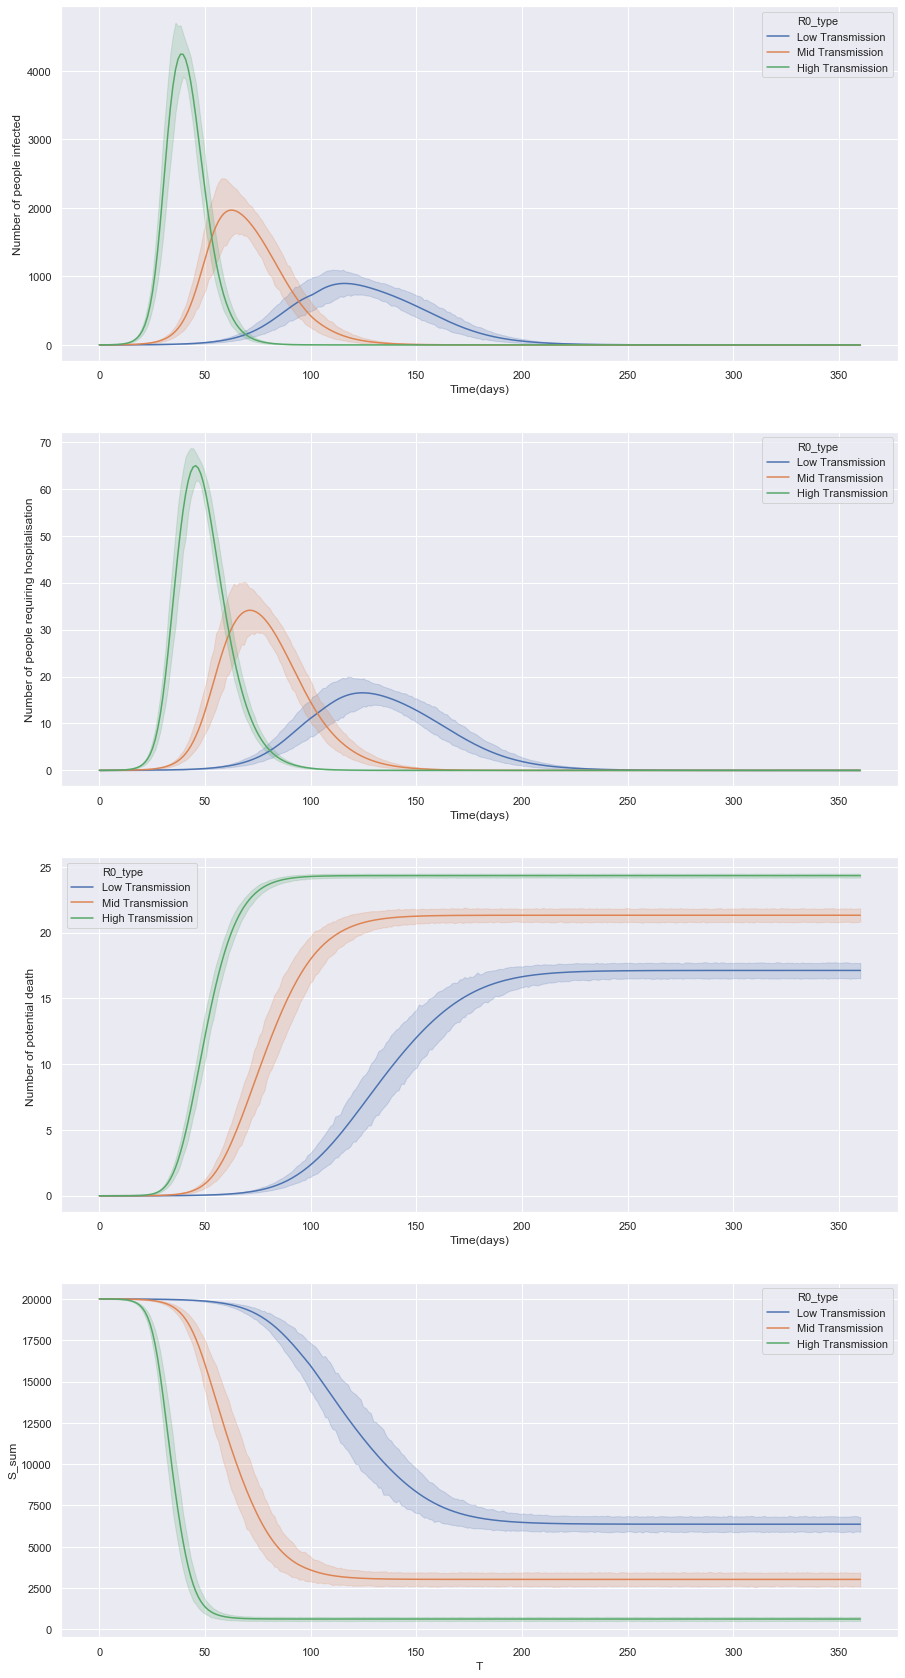

In [221]:
#plot the number of infected, hospitalised, critical cased, dead people in the next 360 days (roughly a year) on a subplot
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,30))
sns.lineplot(x="T", y="I_sum", hue='R0_type', data=sol_frame_total,ax=ax1)
sns.lineplot(x="T", y="H_sum", hue='R0_type', data=sol_frame_total,ax=ax2)
sns.lineplot(x="T", y="D_sum", hue='R0_type', data=sol_frame_total,ax=ax3)
sns.lineplot(x="T", y="S_sum", hue='R0_type', data=sol_frame_total,ax=ax4)
ax1.set_xlabel('Time(days)')
ax2.set_xlabel('Time(days)')
ax3.set_xlabel('Time(days)')
ax1.set_ylabel('Number of people infected')
ax2.set_ylabel('Number of people requiring hospitalisation')
ax3.set_ylabel('Number of potential death ')

In [211]:
example_population_frame.Population=example_population_frame.Moria/example_population_frame.Moria.sum()*100

In [160]:
#plot different age brackets to see for each categories
#split into three brackets : 0-20 young population 20-60 adult population 60+ old population
sol_frame_total['I_young']=sol_frame_total['I0']+sol_frame_total['I1']
sol_frame_total['I_adult']=sol_frame_total['I2']+sol_frame_total['I3']+sol_frame_total['I4']+sol_frame_total['I5']
sol_frame_total['I_old']=

Index(['S0', 'E0', 'I0', 'R0', 'H0', 'C0', 'D0', 'S1', 'E1', 'I1', 'R1', 'H1',
       'C1', 'D1', 'S2', 'E2', 'I2', 'R2', 'H2', 'C2', 'D2', 'S3', 'E3', 'I3',
       'R3', 'H3', 'C3', 'D3', 'S4', 'E4', 'I4', 'R4', 'H4', 'C4', 'D4', 'S5',
       'E5', 'I5', 'R5', 'H5', 'C5', 'D5', 'S6', 'E6', 'I6', 'R6', 'H6', 'C6',
       'D6', 'S7', 'E7', 'I7', 'R7', 'H7', 'C7', 'D7', 'S8', 'E8', 'I8', 'R8',
       'H8', 'C8', 'D8', 'S9', 'E9', 'I9', 'R9', 'H9', 'C9', 'D9', 'R0_type',
       'T', 'S_sum', 'E_sum', 'I_sum', 'R_sum', 'H_sum', 'C_sum', 'D_sum'],
      dtype='object')